In [14]:
import pandas as pd
import numpy as np
import yaml
import logging
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from utilities.utilities import read_ac_data, add_gdp_cdd_data
from utilities.plotting import plot_exposure_contour

In [15]:
# Load configuration from config.yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Set logging level
logging.basicConfig(level=config["logging_level"])

In [16]:
# Read the air conditioning data from the EIA and GDL

# EIA data of AC access from 2018
ac_data_eia = read_ac_data(config['ac_historical_file_iea'], 2018, skip=3)

# GDL data from multiple years
ac_data_gdl = read_ac_data(config['ac_historical_file_gdl'])

# Read OECD data
ac_data_oecd = read_ac_data(config['ac_historical_file_oecd'], 2011)

# Merge the two dataframes
ac_data = pd.concat([ac_data_gdl, ac_data_eia]) #ac_data_oecd,
# ac_data = ac_data_eia

ac_data = add_gdp_cdd_data(ac_data, config)
ac_data = ac_data.dropna()
ac_data["GDP"] = pd.to_numeric(ac_data["GDP"], errors='coerce')

# If there are multiple entries for the same country, only keep the one with the largest year
ac_data = ac_data.drop_duplicates('ISO3', keep='last')

print(ac_data)

# Save the data to a csv file
ac_data.to_csv("heat_exposure_data.csv")


          country    AC  Year ISO3          CDD           GDP
0       Australia  0.75  2011  AUS   566.043839  45405.365365
1          Canada  0.48  2011  CAN   211.160846  45823.164240
3     Netherlands  0.11  2011  NLD    40.039356  52594.229006
4           Spain  0.54  2011  ESP   568.990309  36883.322978
5          Sweden  0.20  2011  SWE    33.273670  48947.439311
..            ...   ...   ...  ...          ...           ...
120        Mexico  0.16  2018  MEX  1036.229873  20278.216307
121        Brazil  0.16  2018  BRA  1749.068014  14619.591130
122     Indonesia  0.09  2018  IDN  2371.722938  11397.431401
123  South Africa  0.06  2018  ZAF   715.544421  13990.314893
124         India  0.05  2018  IND  2756.291905   6436.153402

[74 rows x 6 columns]


In [17]:
def sat(cdd, a):
    return 1. - np.exp(-a * cdd)

# Corrected avail function
def avail(gdp, b, c):
    return 1 / (1 + np.exp(b) * np.exp(-c * gdp))

# Adjusted exposure function to fit the curve_fit requirements
def exposure(xdata, a, b, c):
    cdd, gdp = xdata
    return (sat(cdd, a) * avail(gdp, b, c))

def fit_log_exposure(xdata, a, b, c):
    cdd, gdp = xdata
    return np.log(sat(cdd, a) * avail(gdp, b, c))

def minimize_exposure(p, xdata, ydata):
    return abs(np.sum((fit_log_exposure(xdata, *p) - ydata)**2))

# Prepare xdata as a tuple of CDD and GDP, ydata as AC
xdata = (np.log(ac_data["CDD"]/1000.), np.log(ac_data["GDP"]/10000.))
ydata = np.log(ac_data["AC"])

# Fit the exposure function
# popt, pcov = curve_fit(fit_log_exposure, xdata, ydata)
from scipy.optimize import minimize
popt = minimize(minimize_exposure, [5., 3., 1.], args=(xdata, ydata)).x
print(popt)

[329.94792928   2.28885911   1.31272567]


/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
popt[0] /= 1000
popt[2] /= 10000
print(popt)

[3.29947929e-01 2.28885911e+00 1.31272567e-04]


In [19]:
# Add column to ac_data with the fitted exposure function
ac_data["AC calculated"] = sat(ac_data["CDD"], popt[0]) * avail(ac_data["GDP"], popt[1], popt[2])
print(ac_data)

          country    AC  Year ISO3          CDD           GDP  AC calculated
0       Australia  0.75  2011  AUS   566.043839  45405.365365       0.975196
1          Canada  0.48  2011  CAN   211.160846  45823.164240       0.976488
3     Netherlands  0.11  2011  NLD    40.039356  52594.229006       0.990196
4           Spain  0.54  2011  ESP   568.990309  36883.322978       0.927769
5          Sweden  0.20  2011  SWE    33.273670  48947.439311       0.984257
..            ...   ...   ...  ...          ...           ...            ...
120        Mexico  0.16  2018  MEX  1036.229873  20278.216307       0.592211
121        Brazil  0.16  2018  BRA  1749.068014  14619.591130       0.408612
122     Indonesia  0.09  2018  IDN  2371.722938  11397.431401       0.311592
123  South Africa  0.06  2018  ZAF   715.544421  13990.314893       0.388811
124         India  0.05  2018  IND  2756.291905   6436.153402       0.190932

[74 rows x 7 columns]


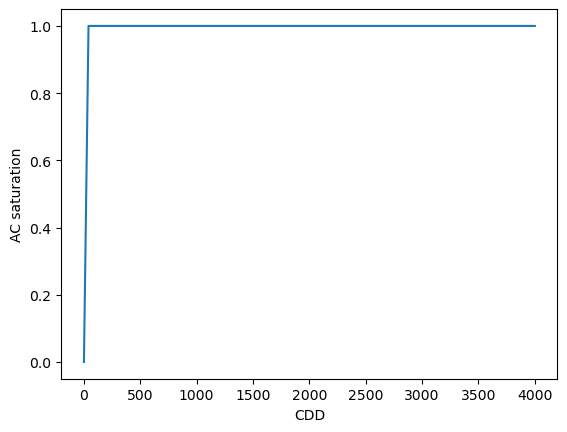

In [20]:
# Plot saturation function
cdd = np.linspace(0, 4000, 100)
plt.plot(cdd, sat(cdd, popt[0]))
plt.xlabel("CDD")
plt.ylabel("AC saturation")
plt.show()

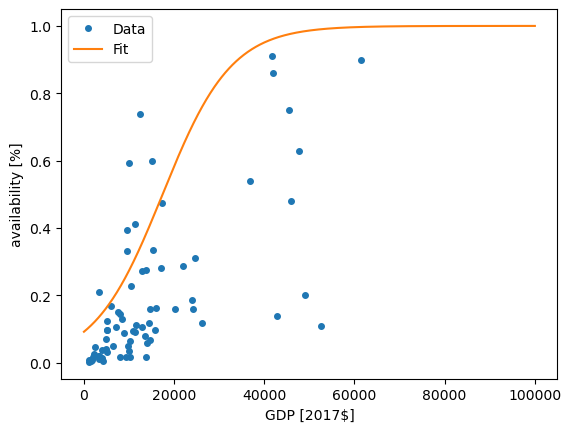

In [21]:
# Plot the availability function
fig, ax = plt.subplots()
ax.plot(ac_data["GDP"], ac_data["AC"]/sat(ac_data["CDD"], popt[0]), 'o', label="Data", markersize=4)
x = np.linspace(0, 100000, 1000)
y = avail(x, popt[1], popt[2])
ax.plot(x, y, label="Fit")
ax.set_xlabel("GDP [2017$]")
ax.set_ylabel("availability [%]")
ax.legend()

In [22]:
# Alternative fit function

def ac_gdp_function(gdp, a, b):
    return (gdp**a / (gdp**a + b**a))

popt_gdp, pcov_gdp = curve_fit(ac_gdp_function, ac_data["GDP"]/100000., ac_data["AC"])
popt_gdp
print(popt_gdp)

[1.14787098 0.43706008]


/tmp/ipykernel_2820620/3955890797.py:4: RuntimeWarning: invalid value encountered in scalar power
  return (gdp**a / (gdp**a + b**a))


Text(0, 0.5, 'AC adoption')

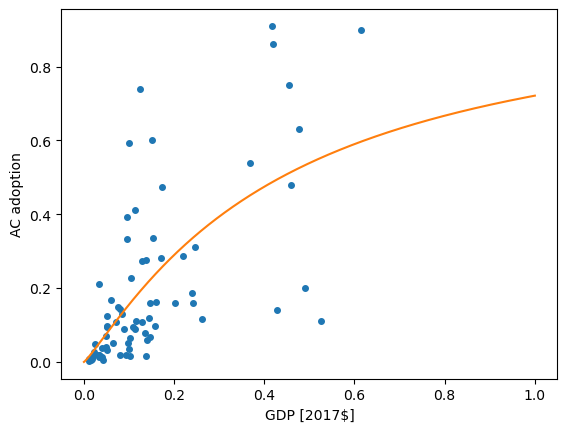

In [23]:
# Plot the fit
fig, ax = plt.subplots()
gdp_range = np.linspace(0, 1, 1000)
ax.plot(ac_data["GDP"]/100000., ac_data["AC"], 'o', label="Data", markersize=4)
ax.plot(gdp_range, ac_gdp_function(gdp_range, *popt_gdp), label="Fit")
ax.set_xlabel("GDP [2017$]")
ax.set_ylabel("AC adoption")

In [24]:
ac_data["AC calculated gdp"] = ac_gdp_function(ac_data["GDP"]/100000., *popt_gdp)
print(ac_data)

          country    AC  Year ISO3          CDD           GDP  AC calculated  \
0       Australia  0.75  2011  AUS   566.043839  45405.365365       0.975196   
1          Canada  0.48  2011  CAN   211.160846  45823.164240       0.976488   
3     Netherlands  0.11  2011  NLD    40.039356  52594.229006       0.990196   
4           Spain  0.54  2011  ESP   568.990309  36883.322978       0.927769   
5          Sweden  0.20  2011  SWE    33.273670  48947.439311       0.984257   
..            ...   ...   ...  ...          ...           ...            ...   
120        Mexico  0.16  2018  MEX  1036.229873  20278.216307       0.592211   
121        Brazil  0.16  2018  BRA  1749.068014  14619.591130       0.408612   
122     Indonesia  0.09  2018  IDN  2371.722938  11397.431401       0.311592   
123  South Africa  0.06  2018  ZAF   715.544421  13990.314893       0.388811   
124         India  0.05  2018  IND  2756.291905   6436.153402       0.190932   

     AC calculated gdp  
0             